# ***Analysing a Social Network Using Graph Neural Network***

In [2]:
!pip install torch_geometric
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.3 MB/s eta 0:00:00


In [4]:
import torch
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import Linear
from torch_geometric.nn import GCNConv

In [5]:
dataset = KarateClub()
data = dataset[0]
print(data)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


In [6]:
print(dataset.num_features)

34


In [25]:
import pandas as pd
node_features_df=pd.DataFrame(data.x.numpy(),columns=[f'features{i}' for i in range(data.x.shape[1])])
node_features_df['node']=node_features_df.index
node_features_df.set_index('node', inplace=True)
# Transpose the edge index data to match the expected shape for the DataFrame
edge_index_df=pd.DataFrame(data.edge_index.numpy().T,columns=['source','target'])
labels_df=pd.DataFrame(data.y.numpy(),columns=['label'])
labels_df['node']=labels_df.index
labels_df.set_index('node',inplace=True)

In [20]:
print(node_features_df)

      features0  features1  features2  features3  features4  features5  \
node                                                                     
0           1.0        0.0        0.0        0.0        0.0        0.0   
1           0.0        1.0        0.0        0.0        0.0        0.0   
2           0.0        0.0        1.0        0.0        0.0        0.0   
3           0.0        0.0        0.0        1.0        0.0        0.0   
4           0.0        0.0        0.0        0.0        1.0        0.0   
5           0.0        0.0        0.0        0.0        0.0        1.0   
6           0.0        0.0        0.0        0.0        0.0        0.0   
7           0.0        0.0        0.0        0.0        0.0        0.0   
8           0.0        0.0        0.0        0.0        0.0        0.0   
9           0.0        0.0        0.0        0.0        0.0        0.0   
10          0.0        0.0        0.0        0.0        0.0        0.0   
11          0.0        0.0        0.0 

In [21]:
num_nodes = data.num_nodes
print(f"Number of nodes: {num_nodes}")

Number of nodes: 34


In [22]:
num_edges = data.edge_index.shape[1]
print(f"Number of edges: {num_edges}")

Number of edges: 156


In [23]:
print(f"\nNode features (shape: {node_features_df.shape}):")
print(node_features_df.head())


Node features (shape: (34, 34)):
      features0  features1  features2  features3  features4  features5  \
node                                                                     
0           1.0        0.0        0.0        0.0        0.0        0.0   
1           0.0        1.0        0.0        0.0        0.0        0.0   
2           0.0        0.0        1.0        0.0        0.0        0.0   
3           0.0        0.0        0.0        1.0        0.0        0.0   
4           0.0        0.0        0.0        0.0        1.0        0.0   

      features6  features7  features8  features9  ...  features24  features25  \
node                                              ...                           
0           0.0        0.0        0.0        0.0  ...         0.0         0.0   
1           0.0        0.0        0.0        0.0  ...         0.0         0.0   
2           0.0        0.0        0.0        0.0  ...         0.0         0.0   
3           0.0        0.0        0.0     

In [26]:
print(f"\nEdge indices (shape: {edge_index_df.shape}):")
print(edge_index_df.head())


Edge indices (shape: (156, 2)):
   source  target
0       0       1
1       0       2
2       0       3
3       0       4
4       0       5


In [27]:
print(f"\nLabels (shape: {labels_df.shape}):")
print(labels_df.head())


Labels (shape: (34, 1)):
      label
node       
0         1
1         1
2         1
3         1
4         3


In [36]:
# Number of countries
num_countries = 13

# Assign students to countries (labels)
np.random.seed(42)  # For reproducibility
countries = torch.tensor(np.random.choice(num_countries, data.num_nodes))

# Update the labels in the data object
data.y = countries

In [37]:
print(data)
print(f'x = {data.x.shape}')
print(data.x)
print(f'edge_index = {data.edge_index.shape}')
print(data.edge_index)
print(f'y = {data.y.shape}')
print(data.y)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
x = torch.Size([34, 34])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
edge_index = torch.Size([2, 156])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 

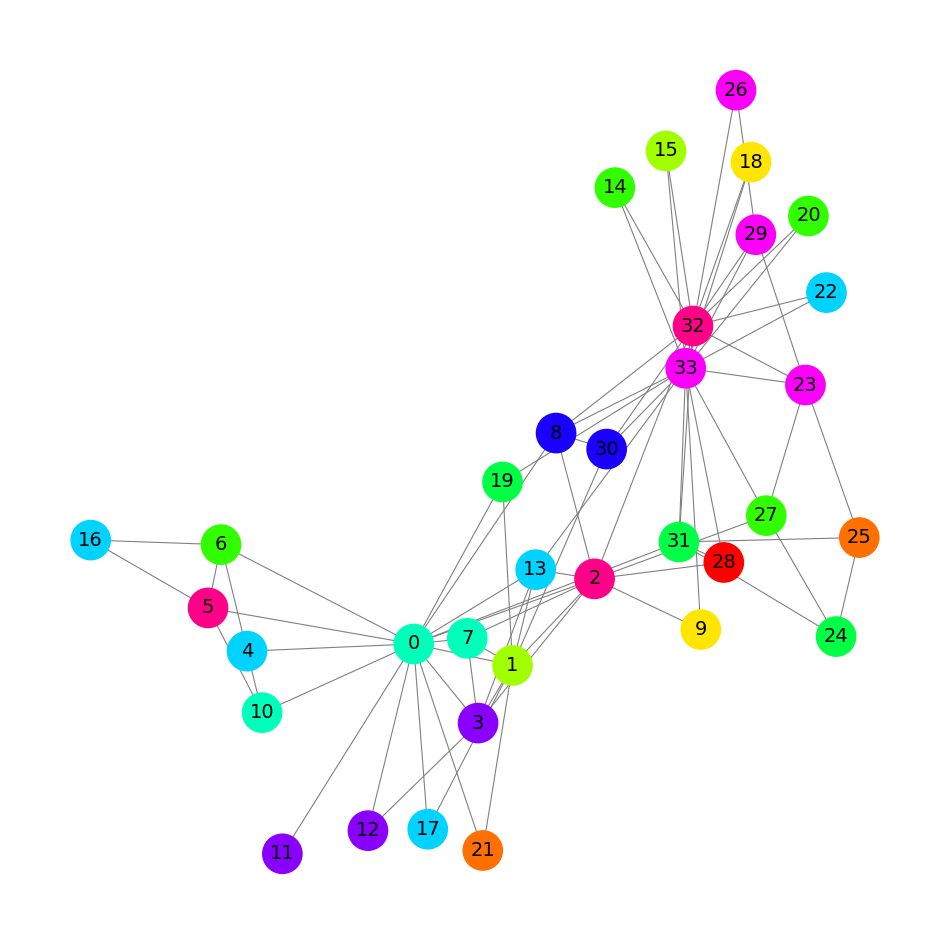

In [38]:
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=2),
                with_labels=True,
                node_size=800,
                node_color=data.y,
                cmap="hsv",
                vmin=0,
                vmax=13,
                width=0.8,
                edge_color="grey",
                font_size=14
                )
plt.show()

In [32]:
print(data.y)

tensor([6, 3, 4, 6, 2, 4, 4, 6, 1, 2, 6, 2, 2, 4, 3, 2, 5, 4, 1, 3, 5, 5, 1, 3,
        4, 0, 3, 1, 5, 4, 3, 0, 0, 2])


In [39]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(dataset.num_features, 3)
        self.out = Linear(3, num_countries)
    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()
        z = self.out(h)
        return h, z

model = GCN()
print(model)


GCN(
  (gcn): GCNConv(34, 3)
  (out): Linear(in_features=3, out_features=13, bias=True)
)


In [40]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

# Calculate accuracy
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

In [41]:
# Data for animations
embeddings = []
losses = []
accuracies = []
outputs = []

# Training loop
for epoch in range(200):
    optimizer.zero_grad()
    h, z = model(data.x, data.edge_index)
    loss = criterion(z, data.y)
    acc = accuracy(z.argmax(dim=1), data.y)
    loss.backward()
    optimizer.step()
    embeddings.append(h)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(z.argmax(dim=1))
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')

Epoch   0 | Loss: 2.65 | Acc: 14.71%
Epoch  10 | Loss: 2.53 | Acc: 14.71%
Epoch  20 | Loss: 2.39 | Acc: 14.71%
Epoch  30 | Loss: 2.21 | Acc: 20.59%
Epoch  40 | Loss: 1.97 | Acc: 32.35%
Epoch  50 | Loss: 1.73 | Acc: 47.06%
Epoch  60 | Loss: 1.51 | Acc: 50.00%
Epoch  70 | Loss: 1.33 | Acc: 67.65%
Epoch  80 | Loss: 1.18 | Acc: 67.65%
Epoch  90 | Loss: 1.05 | Acc: 67.65%
Epoch 100 | Loss: 0.95 | Acc: 70.59%
Epoch 110 | Loss: 0.85 | Acc: 76.47%
Epoch 120 | Loss: 0.77 | Acc: 79.41%
Epoch 130 | Loss: 0.70 | Acc: 82.35%
Epoch 140 | Loss: 0.64 | Acc: 85.29%
Epoch 150 | Loss: 0.58 | Acc: 88.24%
Epoch 160 | Loss: 0.54 | Acc: 91.18%
Epoch 170 | Loss: 0.50 | Acc: 91.18%
Epoch 180 | Loss: 0.47 | Acc: 91.18%
Epoch 190 | Loss: 0.43 | Acc: 91.18%


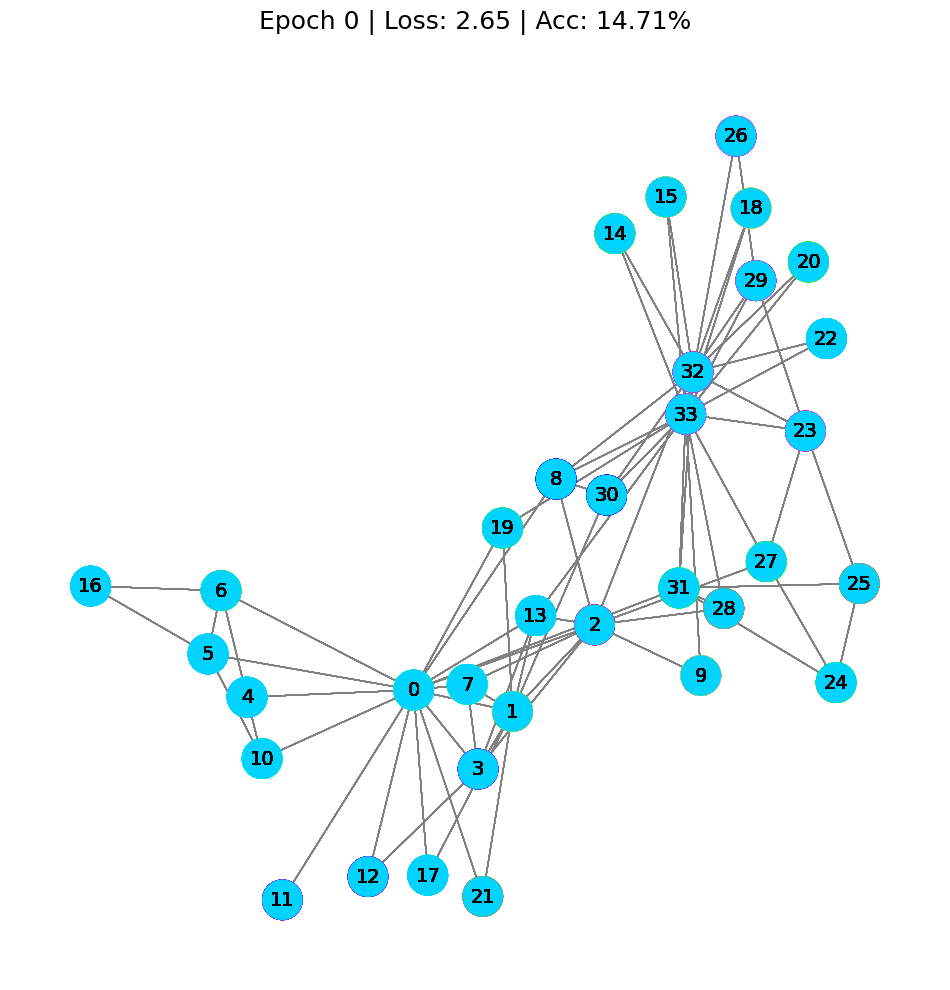

In [45]:
from IPython.display import HTML
from matplotlib import animation

plt.rcParams["animation.bitrate"] = 3000

def animate(i):
    G = to_networkx(data, to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=2),
                    with_labels=True,
                    node_size=800,
                    node_color=outputs[i].numpy(),
                    cmap="hsv",
                    vmin=0,
                    vmax=13,
                    width=0.8,
                    edge_color="grey",
                    font_size=14
                    )
    plt.title(f'Epoch {i} | Loss: {losses[i].item():.2f} | Acc: {accuracies[i].item()*100:.2f}%',
              fontsize=18, pad=20)

fig = plt.figure(figsize=(12, 12))
plt.axis('off')
anim = animation.FuncAnimation(fig, animate, np.arange(0, 200, 10), interval=500, repeat=True)
html = HTML(anim.to_html5_video())
display(html)

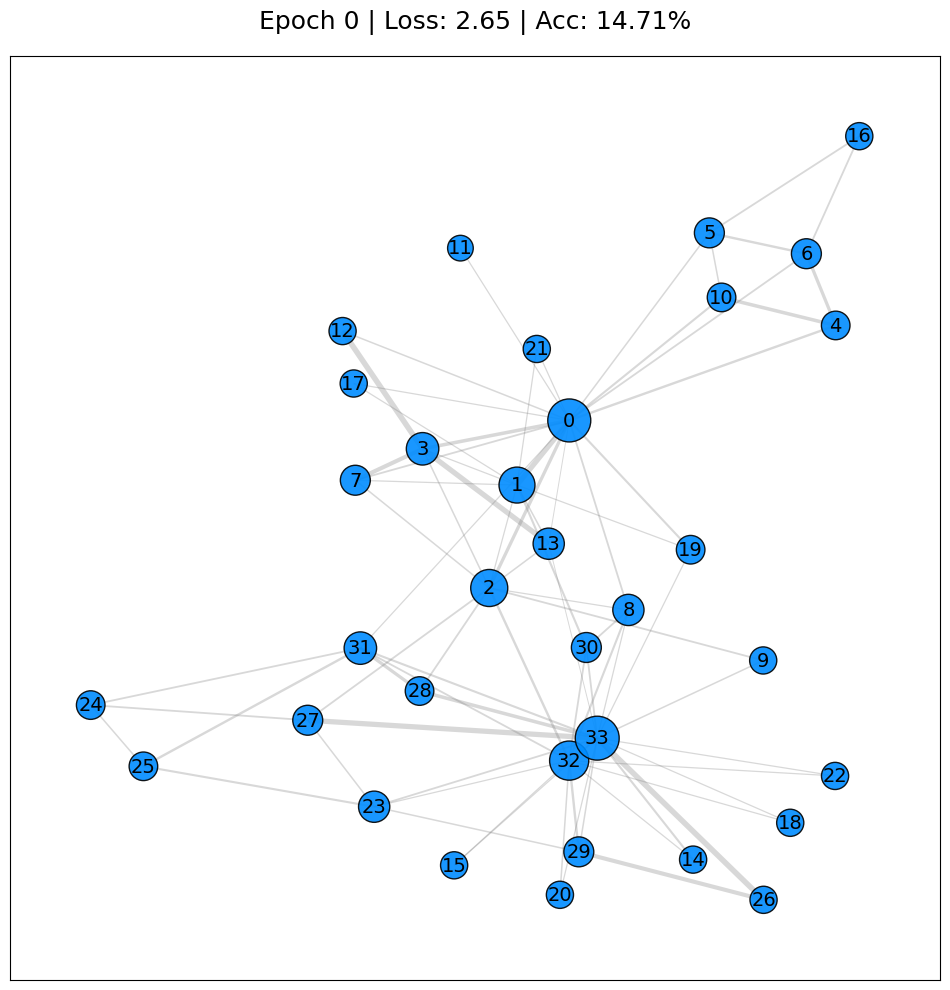

In [46]:
from IPython.display import HTML
from matplotlib import animation

plt.rcParams["animation.bitrate"] = 5000

# Define node and edge properties based on degree
def get_node_edge_properties(G):
    degrees = dict(G.degree())
    max_degree = max(degrees.values())

    node_sizes = [300 + 700 * (deg / max_degree) for deg in degrees.values()]
    edge_widths = [0.5 + 3.5 * (deg / max_degree) for deg in degrees.values()]

    return node_sizes, edge_widths

# Animation function
def animate(i):
    plt.clf()  # Clear the current figure to avoid overlapping drawings
    G = to_networkx(data, to_undirected=True)

    pos = nx.spring_layout(G, seed=0)  # Fixed layout for consistency
    node_sizes, edge_widths = get_node_edge_properties(G)

    nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color="grey", width=edge_widths)
    nodes = nx.draw_networkx_nodes(G, pos,
                                   node_size=node_sizes,
                                   node_color=outputs[i].numpy(),
                                   cmap="hsv",
                                   vmin=0,
                                   vmax=num_countries - 1,
                                   alpha=0.9)
    nx.draw_networkx_labels(G, pos, font_size=14, font_color='black')

    plt.title(f'Epoch {i} | Loss: {losses[i].item():.2f} | Acc: {accuracies[i].item() * 100:.2f}%',
              fontsize=18, pad=20)
    nodes.set_edgecolor('black')  # Add a border to the nodes for better visibility

fig = plt.figure(figsize=(12, 12))
plt.axis('off')

anim = animation.FuncAnimation(fig, animate, frames=np.arange(0, 200, 10), interval=500, repeat=True)
html = HTML(anim.to_html5_video())
display(html)


Final embeddings = torch.Size([34, 3])
tensor([[4.4877e-01, 0.0000e+00, 0.0000e+00],
        [3.4348e-03, 1.2619e+00, 0.0000e+00],
        [8.6290e-01, 0.0000e+00, 1.3380e+00],
        [4.8733e-04, 0.0000e+00, 0.0000e+00],
        [2.1889e+00, 0.0000e+00, 0.0000e+00],
        [1.8705e+00, 0.0000e+00, 0.0000e+00],
        [3.1438e+00, 1.4182e-03, 0.0000e+00],
        [5.6441e-01, 1.0528e-02, 0.0000e+00],
        [7.2478e-01, 2.1499e+00, 1.8992e+00],
        [5.3981e-02, 1.1905e+00, 2.4182e+00],
        [1.3364e+00, 0.0000e+00, 0.0000e+00],
        [5.2042e-03, 8.3241e-02, 1.1908e-01],
        [0.0000e+00, 4.8783e-02, 6.8374e-02],
        [1.1372e+00, 8.9330e-01, 5.6679e-03],
        [1.8846e+00, 1.1064e+00, 1.5805e+00],
        [0.0000e+00, 1.9657e+00, 1.1915e+00],
        [2.5023e+00, 5.8836e-01, 0.0000e+00],
        [1.8251e+00, 9.5388e-01, 0.0000e+00],
        [1.6956e-01, 1.1580e+00, 2.3998e+00],
        [1.4664e+00, 2.5679e+00, 4.3801e-01],
        [1.8911e+00, 1.0622e+00, 1.5472e+

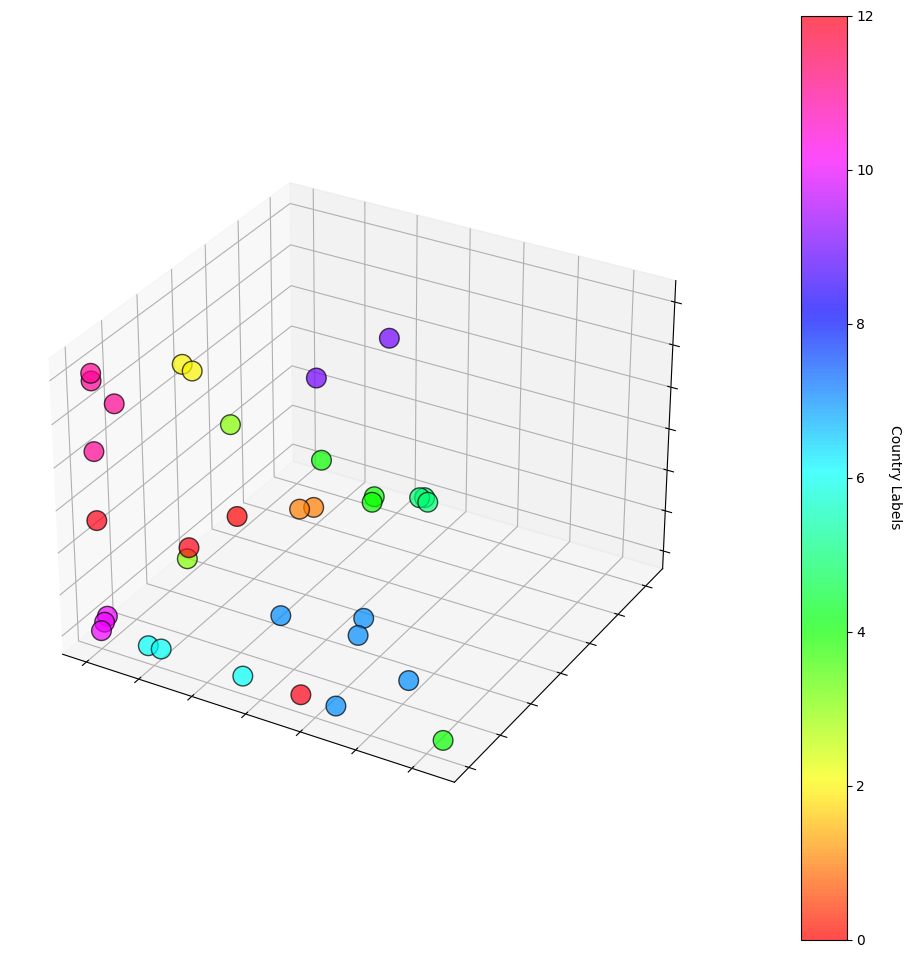

In [47]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Print the shape and values of the final embeddings
print(f'Final embeddings = {h.shape}')
print(h)

# Convert embeddings to a NumPy array
embed = h.detach().cpu().numpy()

# Create a 3D plot for the final embeddings
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.patch.set_alpha(0)  # Transparent background

# Configure the plot
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
sc = ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
                s=200, c=data.y, cmap="hsv", vmin=0, vmax=num_countries - 1, edgecolor='k', alpha=0.7)

# Add a color bar
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('Country Labels', rotation=270, labelpad=20)
plt.show()


Final embeddings = torch.Size([34, 3])
tensor([[4.4877e-01, 0.0000e+00, 0.0000e+00],
        [3.4348e-03, 1.2619e+00, 0.0000e+00],
        [8.6290e-01, 0.0000e+00, 1.3380e+00],
        [4.8733e-04, 0.0000e+00, 0.0000e+00],
        [2.1889e+00, 0.0000e+00, 0.0000e+00],
        [1.8705e+00, 0.0000e+00, 0.0000e+00],
        [3.1438e+00, 1.4182e-03, 0.0000e+00],
        [5.6441e-01, 1.0528e-02, 0.0000e+00],
        [7.2478e-01, 2.1499e+00, 1.8992e+00],
        [5.3981e-02, 1.1905e+00, 2.4182e+00],
        [1.3364e+00, 0.0000e+00, 0.0000e+00],
        [5.2042e-03, 8.3241e-02, 1.1908e-01],
        [0.0000e+00, 4.8783e-02, 6.8374e-02],
        [1.1372e+00, 8.9330e-01, 5.6679e-03],
        [1.8846e+00, 1.1064e+00, 1.5805e+00],
        [0.0000e+00, 1.9657e+00, 1.1915e+00],
        [2.5023e+00, 5.8836e-01, 0.0000e+00],
        [1.8251e+00, 9.5388e-01, 0.0000e+00],
        [1.6956e-01, 1.1580e+00, 2.3998e+00],
        [1.4664e+00, 2.5679e+00, 4.3801e-01],
        [1.8911e+00, 1.0622e+00, 1.5472e+

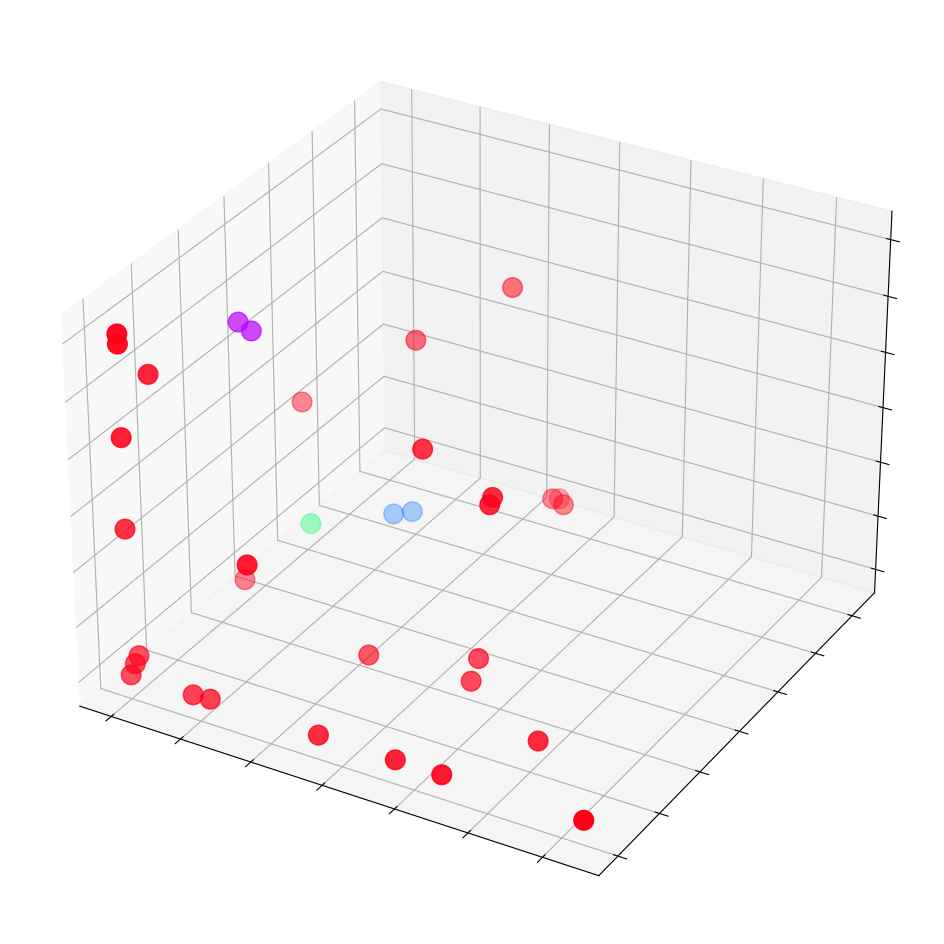

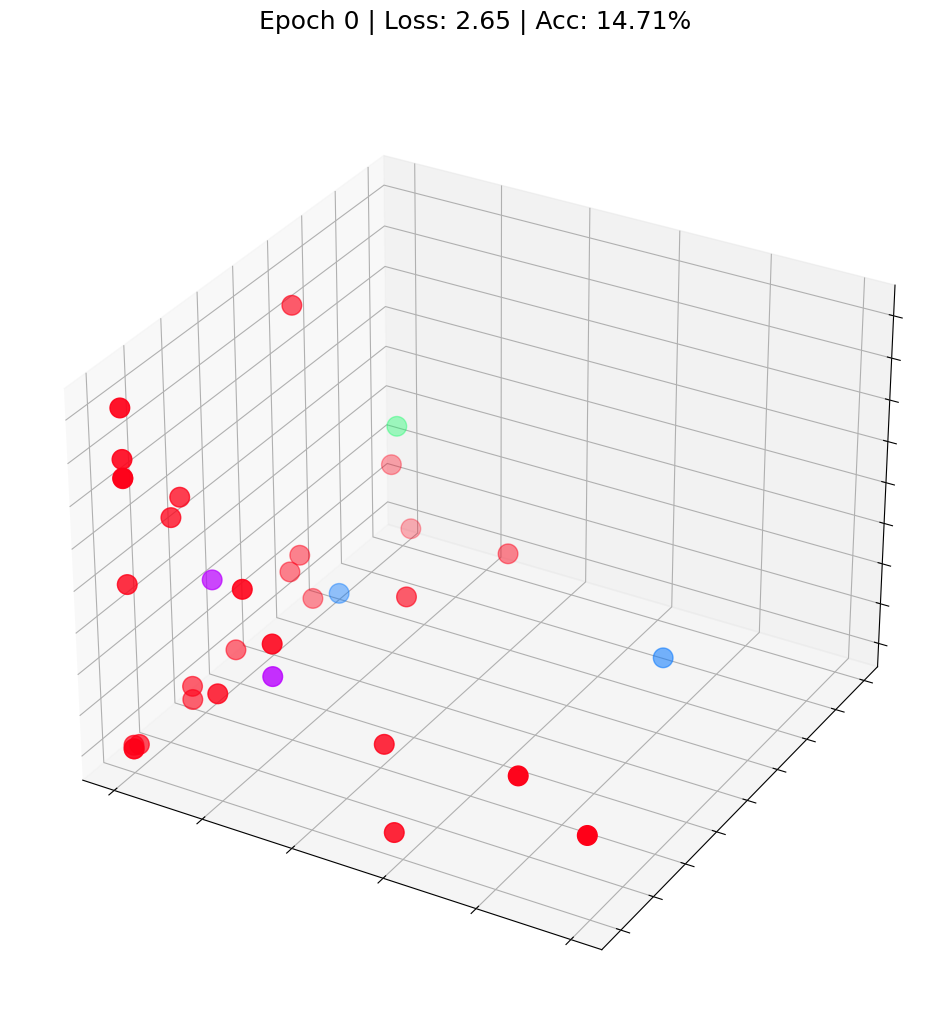

In [49]:
# 3D Embeddings Visualization
print(f'Final embeddings = {h.shape}')
print(h)

embed = h.detach().cpu().numpy()
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.patch.set_alpha(0)
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)
plt.show()

def animate_3d(i):
    embed = embeddings[i].detach().cpu().numpy()
    ax.clear()
    ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
               s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)
    plt.title(f'Epoch {i} | Loss: {losses[i].item():.2f} | Acc: {accuracies[i].item()*100:.2f}%',
              fontsize=18, pad=40)

fig = plt.figure(figsize=(12, 12))
plt.axis('off')
ax = fig.add_subplot(projection='3d')
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
anim = animation.FuncAnimation(fig, animate_3d, np.arange(0, 200, 10), interval=800, repeat=True)
html = HTML(anim.to_html5_video())
display(html)